## Collaborative Filtering Based Recommender System

### Importing The Libraries & Loading the DataSet

#### Movies_metadata

In [1]:
!pip install scikit-surprise

In [2]:
# For calculations

import numpy as np

# For Data manipulation & Analysis

import pandas as pd

# For Plotting

import matplotlib.pyplot as plt

# For making Statistical Graphics

import seaborn as sns

# Importing other libraries also for calculations

from datetime import datetime
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from ast import literal_eval

import warnings; warnings.simplefilter('ignore')

# Loading the movies meta data file & Creating a dataframe

movies_metadata = pd.read_csv(r'C:\Users\lenovo\Desktop\Dataset\movies_metadata.csv')

df_moviesmetadata=pd.read_csv(r'C:\Users\lenovo\Desktop\Dataset\movies_metadata.csv') 

print(df_moviesmetadata.shape)
print(df_moviesmetadata.columns)

df_moviesmetadata.head(1)

(45466, 24)
Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0


### Ratings Data

In [3]:
# loading the movie ratings file & Creating a dataframe

import pandas as pd

ratings_data = pd.read_csv(r'C:\Users\lenovo\Desktop\Dataset\ratings_small.csv')

df_ratings=pd.read_csv(r'C:\Users\lenovo\Desktop\Dataset\ratings_small.csv') 

print(df_ratings.shape)
print(df_ratings.columns)

df_ratings.head(3)

(100004, 4)
Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182


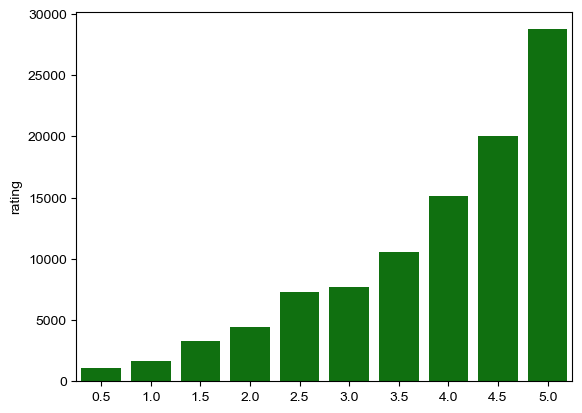

In [4]:
# Statistical Graphics for rankings count

import seaborn as sns

rankings_count = df_ratings.rating.value_counts().sort_values()
sns.barplot(x=rankings_count.index.sort_values(), y=rankings_count, color="g")
sns.set_theme(style="whitegrid")

### Pre - Processing & Cleaning Data

#### Movies_metadata

In [5]:
# Removing invalid records with invalid ids

import pandas as pd
import numpy as np
from datetime import datetime
from ast import literal_eval


df_moviesmetadata = pd.read_csv(r'C:\Users\lenovo\Desktop\Dataset\movies_metadata.csv', low_memory = False)

df_mmeta = df_moviesmetadata.drop([19730, 29503, 35587])
df_movies = pd.DataFrame()

# Considering movies with at least 10 ratings

df_movies = df_mmeta[(df_mmeta['vote_count'] >= 10) & (df_mmeta['vote_average'].notnull())][['title','vote_count','vote_average']]

# Extracting the release year 

df_movies['year'] = pd.to_datetime(df_mmeta['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

# Extracting genres

df_movies['genres'] = df_mmeta['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

# Changing the index to movie_id

df_movies['movieId'] = pd.to_numeric(df_mmeta['id'])
df_movies = df_movies.set_index('movieId')

# Adding vote count

df_movies['vote_count'] = df_movies['vote_count'].astype('int')
df_movies

,title,vote_count,vote_average,year,genres
movieId,,,,,
862,Toy Story,5415,7.7,1995,"[Animation, Comedy, Family]"
8844,Jumanji,2413,6.9,1995,"[Adventure, Fantasy, Family]"
15602,Grumpier Old Men,92,6.5,1995,"[Romance, Comedy]"
31357,Waiting to Exhale,34,6.1,1995,"[Comedy, Drama, Romance]"
11862,Father of the Bride Part II,173,5.7,1995,[Comedy]
...,...,...,...,...,...
49279,The Man with the Rubber Head,29,7.6,1901,"[Comedy, Fantasy, Science Fiction]"
49271,The Devilish Tenant,12,6.7,1909,"[Fantasy, Comedy]"
49280,The One-Man Band,22,6.5,1900,"[Fantasy, Action, Thriller]"


#### Ratings Data

In [6]:
# Droping null values

import pandas as pd

df_ratings_temp = df_ratings.dropna()

# Converting date & time

from datetime import datetime

df_ratings_temp['timestamp'] =  pd.to_datetime(df_ratings_temp['timestamp'], unit='s')

print(f'unique users: {len(df_ratings_temp.userId.unique())}, ratings: {len(df_ratings_temp)}')

df_ratings_temp.head()

unique users: 671, ratings: 100004


,userId,movieId,rating,timestamp
0,1,31,2.5,2009-12-14 02:52:24
1,1,1029,3.0,2009-12-14 02:52:59
2,1,1061,3.0,2009-12-14 02:53:02
3,1,1129,2.0,2009-12-14 02:53:05
4,1,1172,4.0,2009-12-14 02:53:25


#### Splitting the data into Test & Train

In [7]:
import pandas as pd
import numpy as np
from surprise import SVD,Dataset,Reader
from surprise.model_selection import train_test_split, cross_validate

# Reader class is used to parse a file containing ratings

reader = Reader()

df_ratings = pd.read_csv(r'C:\Users\lenovo\Desktop\Dataset\ratings_small.csv')
df_ratings_temp = df_ratings.dropna()
ratings_by_users = Dataset.load_from_df(df_ratings_temp[['userId', 'movieId', 'rating']], reader)

# Spliting the data into train and test

train_df, test_df = train_test_split(ratings_by_users, test_size=.2)

#### Training the SVD Model

In [8]:
# Training a SVD model

from surprise import SVD,Dataset,Reader
from surprise.model_selection import train_test_split, cross_validate

svd_model = SVD()
svd_model_trained = svd_model.fit(train_df)

#### Evaluating & Visualising Prediction Performance Using Cross-Validation

<AxesSubplot:ylabel='Mean Absolute Error'>

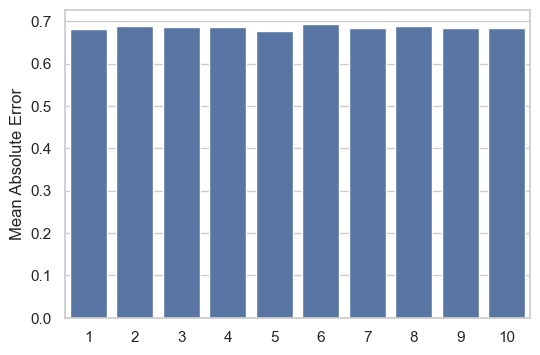

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVD,Dataset,Reader
from surprise.model_selection import train_test_split, cross_validate

# Cross validation 

cross_val_results = cross_validate(svd_model_trained, ratings_by_users, measures=['RMSE', 'MAE', 'MSE'], cv=10, verbose=False)
test_mae = cross_val_results['test_mae']

# Mean squared errors per fold

df_test_mae = pd.DataFrame(test_mae, columns=['Mean Absolute Error'])
df_test_mae.index = np.arange(1, len(df_test_mae) + 1)
df_test_mae.sort_values(by='Mean Absolute Error', ascending=False).head(15)

# Ploting an overview of the performance per fold

plt.figure(figsize=(6,4))
sns.set_theme(style="whitegrid")
sns.barplot(y='Mean Absolute Error', x=df_test_mae.index, data=df_test_mae, color="b")

#### Generating Prediction For UserID & MovieID

In [10]:
# Predicting ratings for the combination of user_id and movie_id

import pandas as pd
import numpy as np
from surprise import SVD,Dataset,Reader
from surprise.model_selection import train_test_split, cross_validate

# Test user from the ratings file

user_id = 400 

# Creating the predictions

pred_series= []
df_ratings_filtered = df_ratings[df_ratings['userId'] == user_id]

print(f'number of ratings: {df_ratings_filtered.shape[0]}')
for movie_id, name in zip(df_movies.index, df_movies['title']):
    
    # Checking if the user has already rated a specific movie from the list or not
    
    rating_real = df_ratings.query(f'movieId == {movie_id}')['rating'].values[0] if movie_id in df_ratings_filtered['movieId'].values else 0
    
    # Generating the prediction
    
    rating_pred = svd_model_trained.predict(user_id, movie_id, rating_real, verbose=False)
    
    # Adding the prediction to the list of predictions
    
    pred_series.append([movie_id, name, rating_pred.est, rating_real])

# Printing the results

df_recommendations = pd.DataFrame(pred_series, columns=['movieId', 'title', 'predicted_rating', 'actual_rating'])
df_recommendations.sort_values(by='predicted_rating', ascending=False).head(15)

number of ratings: 58


,movieId,title,predicted_rating,actual_rating
442,858,Sleepless in Seattle,4.681564,0.0
3194,318,The Million Dollar Hotel,4.583868,5.0
2671,593,Solaris,4.490148,3.0
2097,913,The Thomas Crown Affair,4.455463,0.0
272,2064,While You Were Sleeping,4.445607,0.0
7828,953,Madagascar,4.435930,0.0
8967,1252,Lonely Hearts,4.425086,0.0
795,475,Bonnie and Clyde,4.414797,0.0
9868,31658,Hour of the Gun,4.391583,0.0
232,1945,Nell,4.391410,0.0


#### Predicting Ratings For Single UserID & For All Movies

In [11]:
import pandas as pd
import numpy as np
from surprise import SVD,Dataset,Reader
from surprise.model_selection import train_test_split, cross_validate

# Test user from the ratings file

user_id = 400 

# Creating the predictions

pred_series= []
df_ratings_filtered = df_ratings[df_ratings['userId'] == user_id]

print(f'number of ratings: {df_ratings_filtered.shape[0]}')
for movie_id, name in zip(df_movies.index, df_movies['title']):
    
    # Checking if the user has already rated a specific movie from the list or not
    
    rating_real = df_ratings.query(f'movieId == {movie_id}')['rating'].values[0] if movie_id in df_ratings_filtered['movieId'].values else 0
    
    # Generating the prediction
    
    rating_pred = svd_model_trained.predict(user_id, movie_id, rating_real, verbose=False)
    
    # Adding the prediction to the list of predictions
    
    pred_series.append([movie_id, name, rating_pred.est, rating_real])

# Printing the results

df_recommendations = pd.DataFrame(pred_series, columns=['movieId', 'title', 'predicted_rating', 'actual_rating'])
df_recommendations.sort_values(by='predicted_rating', ascending=False).head(15)

number of ratings: 58


,movieId,title,predicted_rating,actual_rating
442,858,Sleepless in Seattle,4.681564,0.0
3194,318,The Million Dollar Hotel,4.583868,5.0
2671,593,Solaris,4.490148,3.0
2097,913,The Thomas Crown Affair,4.455463,0.0
272,2064,While You Were Sleeping,4.445607,0.0
7828,953,Madagascar,4.435930,0.0
8967,1252,Lonely Hearts,4.425086,0.0
795,475,Bonnie and Clyde,4.414797,0.0
9868,31658,Hour of the Gun,4.391583,0.0
232,1945,Nell,4.391410,0.0


## Collaborative System Has Been Built For Single UserID & For All Movies

                - - - - - - - - X X X X X X X X - - - - - - - -